<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/InitializationStrategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Why Zero Initialization Can Work in Neural Networks: Resolving the Symmetry Problem

**Introduction**

An observation had me scratching my head for several weeks and I finally got the time to sit and resolve it for good. It is well known that setting weights for neural networks to zero is a bad idea and something that almost no one does. But why? Who are the heretics that set it to zero and why does it work for them? The following questions are answered here.

**The Symmetry Problem**

Gemini says that setting weights to zero prevents the symmetry breaking problem where all neurons learn the same weights.

> You should not initialize the weights of a neural network to zero because doing so creates a "symmetry problem" where all neurons in a layer learn the same features, essentially rendering the network ineffective and unable to learn complex patterns; instead, you should initialize weights with small random values to break this symmetry and allow the network to learn diverse features across neurons

This is supported by evidence from deeplearning.ai: [link](https://www.deeplearning.ai/ai-notes/initialization/index.html#:~:text=Initializing%20all%20the%20weights%20with,weights%20with%20some%20constant%20%CE%B1.) and a stackoverflow answer: [link](https://stats.stackexchange.com/questions/45087/why-doesnt-backpropagation-work-when-you-initialize-the-weights-the-same-value).

**The Heretics: ControlNet**

But the heretics of [control net](https://github.com/lllyasviel/ControlNet/blob/main/docs/faq.md) initialize weights and biases of convolution layers to zero and argue not only that this works but is useful as it helps preserve the information learned from the original network when learning to a new style.

**Resolving the Matter**

So let me make the world in my head 0.1% saner by resolving this matter.

The answer to the question of what happens on zero/constant init depends on whether or not you have skip connections.

**Cases:**

- **ReLU Activation, Zero Init, Without Skip:** Weights and biases remain zero in all layers except the bias in the last layer. This is because with ReLU activation and zero weights/biases, the gradients become zero, preventing weight updates.
- **Identity Activation, Zero Init, No Skip:** Similar to the ReLU case, weights remain primarily zero due to zero inputs. The last layer's bias is the exception, receiving updates due to errors in prediction.
- **ReLU Activation, Zero Init, With Skip:** This setup works and breaks symmetry! Skip connections introduce a direct path to inputs, ensuring non-zero gradients for weights and biases, even with zero initialization. This is the key to ControlNet's success.
- **ReLU Activation, Constant Init, Without Skip:** Symmetries are not broken here. Constant initialization leads to identical gradient updates for all weights, preventing the network from learning diverse features.
- **ReLU Activation, Normal Init, No Skip:** This is the regular case. Non-zero, non-equal initialization ensures gradient updates and effective learning.

**Why ControlNet Works**

- **Skip Connections:** ControlNet leverages skip connections, which enable it to preserve information from a pretrained network while adapting to new tasks/styles.
- **Zero Initialization:** By initializing weights to zero, ControlNet initially behaves identically to the frozen pretrained network. The trainable copy then focuses on learning the missing information needed for the new task, benefiting from the preserved knowledge of the original network.


**Some math and code to support the above claims is described below**

### Toy task
I created a toy dataset to help with emprirical evaluations.

#### Imports

In [13]:
# !pip install d2l
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np

#### Dataset creation
- Created 2 random weight tensors and mapped inputs to outputs with 2 layers and a ReLU.

$H_1 = ReLU(W_1X) + b_1$

$Y = H_1X + b_2 + random noise$




In [2]:
class SyntheticRegression(d2l.DataModule):
  def __init__(self, w1, w2, b1, b2, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
    super().__init__()
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, len(w1))
    noise = torch.randn(n, 1) * noise

    # (N, D) * (D, H) = (N, H)
    self.h1 = torch.relu(torch.matmul(self.X, w1)) + b1

    # (N, H) * (H, 1) = (N, 1)
    self.h2 = torch.matmul(self.h1, w2) + b2
    self.y = self.h1 + noise

In [3]:
w1 = torch.randn(2, 2, requires_grad=False)
b1 = torch.randn(2, requires_grad=False)
w2 = torch.randn(2, 2, requires_grad=False)
b2 = torch.randn(2, requires_grad=False)

data = SyntheticRegression(w1, w2, b1, b2, noise=0, num_train=1000, batch_size=500)
d, h = w1.shape[0], w1.shape[1]

print(f"w1 = {w1}")
print(f"b1 = {b1}")
print(f"w2 = {w2}")
print(f"b2 = {b2}")
print(f"d = {d}")
print(f"h = {h}")

w1 = tensor([[-0.5283,  0.3297],
        [-1.4642,  0.4483]])
b1 = tensor([ 1.5154, -1.1128])
w2 = tensor([[-1.4251, -2.2097],
        [ 0.4507,  0.6051]])
b2 = tensor([0.7994, 1.5112])
d = 2
h = 2


#### Some data utility helpers

In [4]:
@d2l.add_to_class(SyntheticRegression)
def get_dataloader(self, train):
  i = slice(0, self.num_train)
  if not train:
    i = slice(self.num_train, self.num_train + self.num_val)
  return self.get_tensorloader((self.X, self.y), train, i)

@d2l.add_to_class(SyntheticRegression)
def train_dataloader(self):
  return self.get_dataloader(train=True)

@d2l.add_to_class(SyntheticRegression)
def val_dataloader(self):
  return self.get_dataloader(train=False)

@d2l.add_to_class(SyntheticRegression)
def plot(self):
  d2l.plot(self.X[:, 0].detach().numpy(), self.y[:,0].detach().numpy(), fmts='.')
  d2l.plt.show()

@d2l.add_to_class(SyntheticRegression)
def visualize(self, model, title=None, labels=None):
  preds = model(self.X)
  plt.scatter(self.X[:, 0].detach().numpy(), self.y[:,0].detach().numpy(), marker='.')
  plt.scatter(self.X[:, 0].detach().numpy(), preds[:,0].detach().numpy(), marker='.')
  plt.show()

@d2l.add_to_class(d2l.Module)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
  tensors = tuple(a[indices] for a in tensors)
  dataset = torch.utils.data.TensorDataset(*tensors)
  return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train) # shuffle only if it is training set



@d2l.add_to_class(d2l.Module)
def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    if hasattr(self, 'training_losses'):
        self.training_losses.append(l.detach().cpu().numpy())  # Append if it exists
    else:
        self.training_losses = [l.detach().cpu().numpy()]  # Create a new list if it doesn't
    self.plot('loss', l, train=True)
    return l

@d2l.add_to_class(d2l.Module)
def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    if hasattr(self, 'validation_losses'):
        self.validation_losses.append(l.detach().cpu().numpy())  # Append if it exists
    else:
        self.validation_losses = [l.detach().cpu().numpy()]  # Create a new list if it doesn't
    self.plot('loss', l, train=False)
    return l


def print_model_weights(model):
  for i in range(len(model.net)):
    if type(model.net[i]) == nn.Linear:
      print(f"W_{i}", model.net[i].weight)
      print(f"b_{i}", model.net[i].bias)
      print('\n')

  print("Final training loss = ", model.training_losses[-1])
  print("Final validation loss = ", model.validation_losses[-1])

  print('\n\n\n')


#### Model
- Defined a linear model with the following architecture

```
        nn.Linear(d, h),
        activation(),
        nn.Linear(h, h),
        nn.Linear(h, 1),
```



In [8]:
class LinearRegression(d2l.Module):
  def __init__(self, d, h, lr, activation=nn.ReLU, init_scheme='xavier', skip=False):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(*[
        nn.Linear(d, h),
        activation(),
        nn.Linear(h, h),
        nn.Linear(h, 1),
    ])
    self.net.apply(self.init_weights)

  def init_weights(self, model):
    if type(model) == nn.Linear:
      init_scheme = self.init_scheme
      if init_scheme == 'normal':
        nn.init.normal_(model.weight, mean=0.0, std=0.01)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'xavier':
        print('xavier works')
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'zeros':
        nn.init.zeros_(model.weight)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'ones':
        nn.init.ones_(model.weight)
        nn.init.ones_(model.bias)

  def forward(self, X):
    if self.skip == False:
      return self.net(X)
    else:
      identity = X
      for i, layer in enumerate(self.net):
        X = layer(X)
        if type(layer) == nn.Linear and i != len(self.net) - 1:
          X += identity
      return X


  def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

  def configure_optimizers(self):
    return torch.optim.Adam(self.net.parameters(), self.lr)


### Case Identity activation, zero init, no skip

#### Math block

If you have,

$H=WX+b$

The gradients of H w.r.t to W is X and w.r.t to B is 1.

$\frac{dH}{dW} = X$

$\frac{dH}{db} = 1$

If you have gradients w.r.t to H that you would like to use to update W.

$\frac{dL}{dW} = \frac{dL}{dH} * \frac{dH}{dW}$

$\frac{dL}{dW} = \frac{dL}{dH} * X$

$\frac{dL}{db} = \frac{dL}{dH}$

So if you a non-zero output gradient and if your inputs are non-zero weights, then $dL/dW\neq0$.
Just having non-zero output gradient will make $dL/db\neq0$

If your inputs are 0, then the gradients are zero.

#### Code block
- Below is the code block to support this
- As you can see weights are zero for all layers. This is because the inputs are zeros in all layers.
- The bias at the last layer gets some weights because gradients for bias in last layer is just 1 and as long as there is some error between prediction and loss, this bias value keeps getting adjusted. This results in lowering of training and validation loss.


W_0 Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
b_0 Parameter containing:
tensor([0., 0.], requires_grad=True)


W_2 Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
b_2 Parameter containing:
tensor([0., 0.], requires_grad=True)


W_3 Parameter containing:
tensor([[0., 0.]], requires_grad=True)
b_3 Parameter containing:
tensor([0.4159], requires_grad=True)


Final training loss =  0.23124723
Final validation loss =  0.21758687






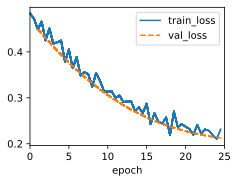

In [25]:
linear_layer_with_no_skip = LinearRegression(d=2, h=2, lr=0.01, init_scheme='zeros', activation=nn.Identity, skip=False)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(linear_layer_with_no_skip, data)
print_model_weights(linear_layer_with_no_skip)

### Case ReLU activation, zero init, without skip
- Once again weights and biases are in all layers except the bias in last layer.

#### Math block

If you have,

$H=ReLU(WX+b)$

The gradients of H w.r.t to W is X and w.r.t to B is 1.

If $ReLU(WX + b) > 0$, it is $\frac{dH}{dW} = X$

Else, it is $\frac{dH}{dW} = 0$

The same calculation for bias.

If $ReLU(WX + b) > 0$, it is $\frac{dH}{dW} = 1$

Else, it is $\frac{dH}{db} = 0$

If W and b are both zero, then $ReLU(WX+b) = 0$, thus the gradients are zero if inputs are zero for both weights and biases.


#### Code block

W_0 Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
b_0 Parameter containing:
tensor([0., 0.], requires_grad=True)


W_2 Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
b_2 Parameter containing:
tensor([0., 0.], requires_grad=True)


W_3 Parameter containing:
tensor([[0., 0.]], requires_grad=True)
b_3 Parameter containing:
tensor([0.4335], requires_grad=True)


Final training loss =  2.977633
Final validation loss =  2.9681826






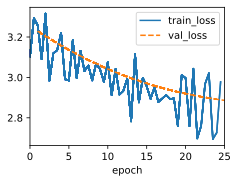

In [6]:
relu_layer_with_no_skip = LinearRegression(d=2, h=2, lr=0.01, init_scheme='zeros', activation=nn.ReLU, skip=False)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(relu_layer_with_no_skip, data)
print_model_weights(relu_layer_with_no_skip)

### Case ReLU activation, zero init, with skip
- This should work and symmetry breaks because inputs are different.

#### Math block
For the first two layers, with skip connection, activations now include a direction connection to inputs.

$H=ReLU(WX+b + X)$

If $ReLU(WX + b + X) > 0$, it is $\frac{dH}{dW} = X$. Now if W and b is 0, as long ax $X > 0, ReLU(WX + b + X) > 0$. Thus weights get updates. Even the symmetry is broken now because in our case 2 dimensions in input are not equal. This is the argument made in the [control net repo](https://github.com/lllyasviel/ControlNet/blob/main/docs/faq.md).  

The same logic applies for bias.

#### Code block

W_0 Parameter containing:
tensor([[ 0.2401, -0.1806],
        [ 0.4913,  0.3769]], requires_grad=True)
b_0 Parameter containing:
tensor([0.2427, 0.0723], requires_grad=True)


W_2 Parameter containing:
tensor([[-0.2945, -0.3805],
        [-0.2735, -0.3798]], requires_grad=True)
b_2 Parameter containing:
tensor([-0.2769, -0.2603], requires_grad=True)


W_3 Parameter containing:
tensor([[-0.1810, -0.3505]], requires_grad=True)
b_3 Parameter containing:
tensor([0.2740], requires_grad=True)


Final training loss =  2.6525578
Final validation loss =  2.7951589






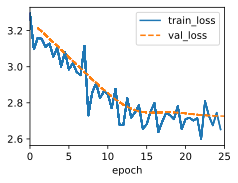

In [9]:
relu_layer_with_skip = LinearRegression(d=2, h=2, lr=0.01, init_scheme='zeros', activation=nn.ReLU, skip=True)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(relu_layer_with_skip, data)
print_model_weights(relu_layer_with_skip)

### Case ReLU activation, constant init, without skip

#### Math block
If we do not have skip connections and have constant init, symmetries will not break.

The intuition I have is loss is a scalar and if weights are the same, gradient updates should be the same. A detailed mathematical description of this case is left as an exercise for the reader.

#### Code block

W_0 Parameter containing:
tensor([[0.6467, 0.6430],
        [0.6467, 0.6430]], requires_grad=True)
b_0 Parameter containing:
tensor([0.6402, 0.6402], requires_grad=True)


W_2 Parameter containing:
tensor([[0.6419, 0.6419],
        [0.6419, 0.6419]], requires_grad=True)
b_2 Parameter containing:
tensor([0.6142, 0.6142], requires_grad=True)


W_3 Parameter containing:
tensor([[0.6355, 0.6355]], requires_grad=True)
b_3 Parameter containing:
tensor([0.5847], requires_grad=True)


Final training loss =  8.912467
Final validation loss =  8.381158






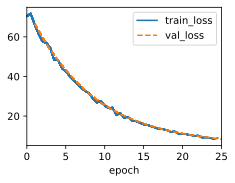

In [11]:
relu_layer_without_skip_constant_init = LinearRegression(d=2, h=2, lr=0.01, init_scheme='ones', activation=nn.ReLU, skip=False)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(relu_layer_without_skip_constant_init, data)
print_model_weights(relu_layer_without_skip_constant_init)

### Case ReLU activation, normal init, no skip

#### Math block
- This is the regular case ! There should be gradients for non-zero, non-equal init.

#### Code block

W_0 Parameter containing:
tensor([[-0.1632, -0.5175],
        [-0.2642, -0.5415]], requires_grad=True)
b_0 Parameter containing:
tensor([0.1772, 0.2240], requires_grad=True)


W_2 Parameter containing:
tensor([[-0.3998, -0.4389],
        [ 0.4084,  0.4176]], requires_grad=True)
b_2 Parameter containing:
tensor([-0.2941,  0.2879], requires_grad=True)


W_3 Parameter containing:
tensor([[-0.3454,  0.3424]], requires_grad=True)
b_3 Parameter containing:
tensor([0.2909], requires_grad=True)


Final training loss =  2.787956
Final validation loss =  2.7987318






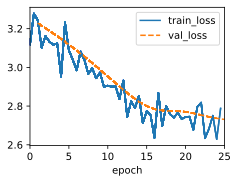

In [12]:
relu_layer_without_skip_normal_init = LinearRegression(d=2, h=2, lr=0.01, init_scheme='normal', activation=nn.ReLU, skip=False)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(relu_layer_without_skip_normal_init, data)
print_model_weights(relu_layer_without_skip_normal_init)

### Why does control net work
- Because it has skip connection ! [Sources for image, og control net](https://arxiv.org/pdf/2302.05543)
- What is the value of initializing weights to 0 ?
  - When weights in Z are initialized to 0, overall network behaves identical to the first frozen network. Information from the pretrained network is always passed to output and the trainable copy is forced to learn the information that is missing from first image but is needed for the task at hand.

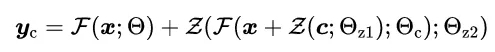

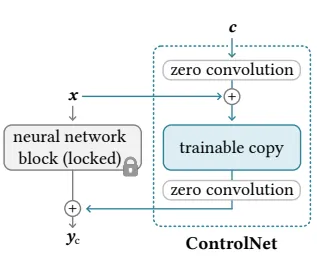